<div style="padding: 30px 60px; border: 5px skyblue solid; border-radius: 30px; max-width: 600px; font-size: 2rem; line-height: 3rem; color: black; font-family: sans-serif;">

  <div style="font-size: 1.5rem; font-weight: 200;">[CM3070] Final Project - BSc CS University of London</div>
  <div style="font-size: 1.5rem; font-weight: 500;">Deep Learning on Satellite Imagery</div>
  <div style="font-size: 2rem; color: dodgerblue; font-weight: bold;">by Arjun Bajaj</div>
</div>

# Transfer Learning Models

In this notebook, Transfer Learning and Model Fine-Tuning is explored and evaluated. The first model is created for the EuroSAT dataset, and then transfer learning is applied to that trained model on the UC Merced Land Use Dataset. A small model is used to demonstrate that it is also possible to use Transfer Learning to train on different datasets and still run inference on microcontrollers.

This is useful as each satellite will have differences in the way they capture images. Fine-tuning towards those differences can boost accuracy effectively.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from core import load_eurosat, load_uc_merced, compile_and_train_model

In [2]:
eurosat_dataset = load_eurosat()
uc_merced_dataset = load_uc_merced(image_size=64, batch_size=16)

Found 21600 files belonging to 10 classes.
Found 2700 files belonging to 10 classes.
Found 2700 files belonging to 10 classes.
Found 1680 files belonging to 21 classes.
Found 210 files belonging to 21 classes.
Found 210 files belonging to 21 classes.


# Building a small model for EuroSAT

The model architecture below has performed quite well on the EuroSAT dataset, and is small enough to run on the Raspberry Pi Pico. This model reaches a `90+%` accuracy after `100+` epochs, but reaches `80+%` accuracy within 30 epochs. Here, the model is trained for 30 epochs to demonstrate transfer learning. To improve the accuracy of the Transfer Learning model, this model can be first trained for more epochs.


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                       

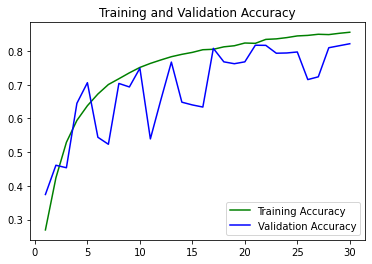

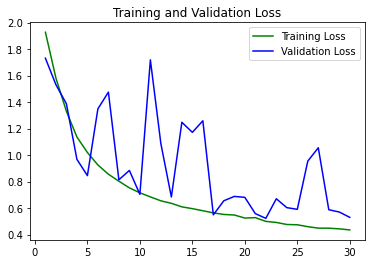

43/43 [==============================] - 1s 15ms/step - loss: 0.5224 - accuracy: 0.8167

Trained for 30 epochs in 5m38s.
Highest Validation Accuracy: 81.67%


In [3]:
inputs = keras.Input(shape=(64, 64, 3))
x = inputs
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation="softmax")(x)
eurosat_model = keras.Model(inputs=inputs, outputs=outputs)
eurosat_model.summary()

compile_and_train_model(
  eurosat_model, "eurosat_for_tl", eurosat_dataset,
  epochs=30, early_stopping=False, learning_rate=0.0065
)

# Building the same model for UC Merced

**No Transfer Learning is used at this step.** The same model architecture as above is used on the UC Merced Dataset. This exercise demonstrates how well a different dataset performs on the architecture the EuroSAT performs considerably well on.

This results in a validation accuracy of `60.95%`. This is significantly lower than EuroSAT's `81.67%`, but pretty good considering there are 21 classes in the UC Merced dataset.

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                       

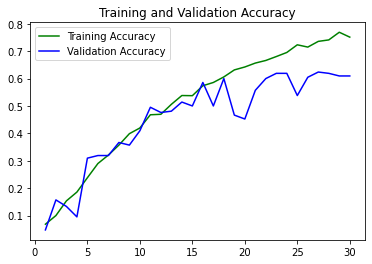

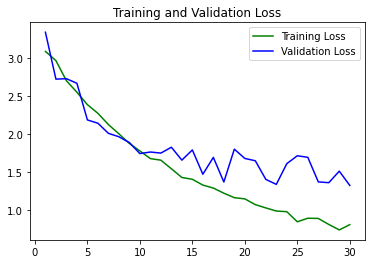

14/14 [==============================] - 0s 10ms/step - loss: 1.3268 - accuracy: 0.6095

Trained for 30 epochs in 0m49s.
Highest Validation Accuracy: 60.95%


In [4]:
inputs = keras.Input(shape=(64, 64, 3))
x = inputs
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(21, activation="softmax")(x)
uc_merced_model = keras.Model(inputs=inputs, outputs=outputs)
uc_merced_model.summary()

compile_and_train_model(
  uc_merced_model, "uc_merced.keras", uc_merced_dataset,
  epochs=30, early_stopping=False, learning_rate=0.0065
)

# Transfer Learning

In this step, the EuroSAT model trained above is loaded, and used to apply Transfer Learning. All layers of the model are set to be untrainable, and the last classifier layer is attached along with a dropout. The classifier is the only trainable layer. This results in an accuracy of `61.9%`, slightly higher than the original model trained on the UC Merced dataset above.

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                      

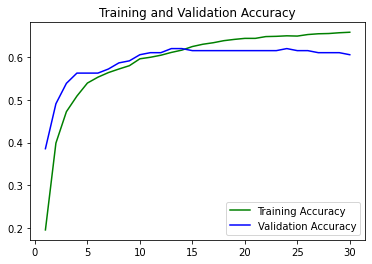

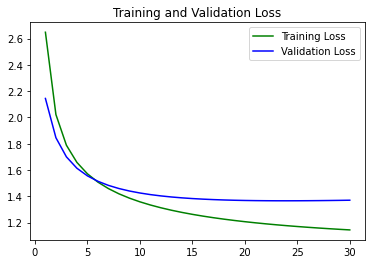

14/14 [==============================] - 0s 10ms/step - loss: 1.3653 - accuracy: 0.6190

Trained for 30 epochs in 0m32s.
Highest Validation Accuracy: 61.90%


In [5]:
tl_model_c = keras.models.load_model('../models/eurosat_for_tl.keras')
tl_model_c.trainable = False
x = tl_model_c.layers[-3].output
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(21, activation="softmax")(x)
tl_model_c = keras.Model(inputs=tl_model_c.input, outputs=outputs)
tl_model_c.summary()

compile_and_train_model(
  tl_model_c, "uc_merced_tl_classifier_only", uc_merced_dataset,
  epochs=30, learning_rate=0.005, early_stopping=False
)

# Model Fine-Tuning

In this step, the EuroSAT model trained above is loaded, but all layers are kept trainable. The `Dropout` and `Dense` classifier layers are attached to the `GlobalAveragePooling2D` layer, same as above.

This leads to an accuracy of `71.9%`, significantly higher than both of the models trained on the UC Merced dataset above.

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                      

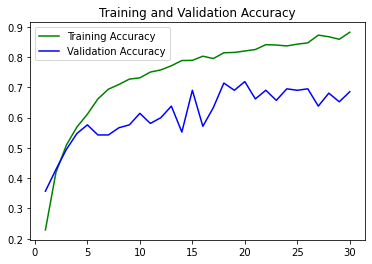

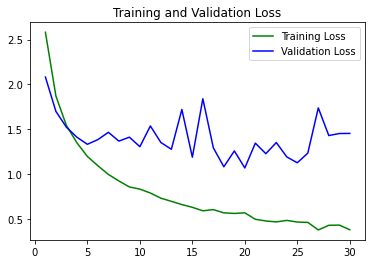

14/14 [==============================] - 0s 10ms/step - loss: 1.0697 - accuracy: 0.7190

Trained for 30 epochs in 0m48s.
Highest Validation Accuracy: 71.90%


In [6]:
eurosat_model = keras.models.load_model('../models/eurosat_for_tl.keras')
eurosat_model.trainable = True
x = eurosat_model.layers[-3].output
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(21, activation="softmax")(x)
tl_model = keras.Model(inputs=eurosat_model.input, outputs=outputs)
tl_model.summary()

compile_and_train_model(
  tl_model, "uc_merced_tl", uc_merced_dataset,
  epochs=30, learning_rate=0.005, early_stopping=False
)

# Conclusion

Model Fine-Tuning enabled a particularly hard-to-train dataset to increase accuracy by `10%` keeping the same number of epochs.

Overall, Model Fine-Tuning was a success on the UC Merced dataset, and can certainly be used to fine-tune models before deploying them to new satellite constellations.

----